In [2]:
import pandas as pd
import numpy as np
from numpy import mean,std
import seaborn as sn
import matplotlib.pyplot as plt
from collections import Counter

#Pre processing and scoring library
from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import KFold,train_test_split,cross_val_score,StratifiedKFold,RepeatedKFold,GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score,precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score,recall_score,f1_score,roc_auc_score, roc_curve,auc

#Model Selection Library
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.linear_model import  LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.multiclass import OneVsRestClassifier


In [3]:
df = pd.read_csv('VOR Train Test.csv')
df = df.drop('ORDER',axis=1)

Features = df.iloc [:,0:-1].values      # Feature Matrix / Independent Variables
Targets, Values = pd.factorize(df["FAULTY PARTS"])      # Target Matrix / Dependent Variable

Targets_unique = np.unique(Targets)
Values_unique = Values
print("Number of orders used is :", Features.shape[0])

# Print Legend of Targets
print('Legend: ')
for Targets_unique,Values_unique in enumerate(Values_unique):
    print (Targets_unique,"=",Values_unique)

Number of orders used is : 35
Legend: 
0 = MICROCIRCUIT 822-0297-001
1 = MICROCIRCUIT 351-1392-180
2 = MICROCIRCUIT 850-1051-230
3 = MICROCIRCUIT 850-1017-020
4 = MICROCIRCUIT 351-0655-010
5 = OSCILLATOR 850-1017-020
6 = OSCILLATOR 850-1051-210


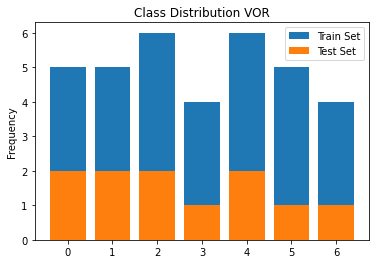

In [10]:
# Split Data to data train and data test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Features,Targets,test_size = 0.3,random_state = 11,stratify=Targets)

# Plot data distribution 
fig, ax = plt.subplots()

labels = list(Counter(Targets).keys())
ytrain = list(Counter(Targets).values())

ax.bar(labels, ytrain, label='Train Set')
ax.set_ylabel('Frequency')
ax.set_title('Class Distribution VOR')
ax.legend()


labels_test = list(Counter(y_test).keys())
ytest = list(Counter(y_test).values())
ax.bar(labels_test, ytest,label='Test Set')
ax.legend()

plt.show()


In [10]:
# Using each params variable that get from each hyperparameter tuning

# Random Forest
rf = RandomForestClassifier(bootstrap=False, max_depth=100, max_features='sqrt', n_estimators=120)

# Gradient Boosting
gb = GradientBoostingClassifier(max_depth=5, max_features='sqrt', n_estimators=50)

# Decision Tree
dt = DecisionTreeClassifier(criterion='entropy', max_depth=8, max_features='log2',max_leaf_nodes=22)

# Naive Bayes
nb =  GaussianNB(var_smoothing=0.43287612810830584)

# K-Nearest Neighbour
knn = KNeighborsClassifier(metric='euclidean', n_neighbors=1)

# Support Vector Machine
svc = OneVsRestClassifier(estimator=SVC(C=100, gamma=0.1, kernel='sigmoid', probability=True))

# Logistic Regression
lr = OneVsRestClassifier(estimator=LogisticRegression(C=100, max_iter=1000,solver='liblinear'))

# Multilayer Perceptron
mlp = MLPClassifier(learning_rate='invscaling', max_iter=5000, solver='lbfgs')

In [11]:
# Fit the model with training set
lr.fit(X_train, y_train)
gb.fit(X_train, y_train)
dt.fit(X_train, y_train)
rf.fit(X_train, y_train)
nb.fit(X_train, y_train)
knn.fit(X_train, y_train)
svc.fit(X_train, y_train)
mlp.fit(X_train, y_train)

MLPClassifier(learning_rate='invscaling', max_iter=5000, solver='lbfgs')

In [4]:
def nested_non_nested (model_used,model_name,parameter,NUM_TRIALS):
  
    p_grid = parameter
    model = model_used

    test_score_not_nested = []
    test_score_nested = []
    
    # Loop for each trial
    for i in range(NUM_TRIALS):

        inner_cv = RepeatedKFold(n_splits=3, random_state=i)
        outer_cv = RepeatedKFold(n_splits=5, random_state=i)

        # Non_nested parameter search and scoring
        clf = GridSearchCV(estimator= model, param_grid=p_grid, cv=outer_cv,refit=True,n_jobs=-1)
        not_nested_fit = clf.fit(X_train, y_train)
        test_score_not_nested.append(clf.best_score_)

        # Nested CV with parameter optimization
        clf = GridSearchCV(estimator=model, param_grid=p_grid, cv=inner_cv,refit=True)
        nested_score = cross_val_score(clf, X_train,y_train,scoring='accuracy', cv=outer_cv, n_jobs=-1)
        test_score_nested.append(nested_score.mean())
        
        
    print("Mean accuracy Not nested CV: {:.1f}% ".format(mean(test_score_not_nested)*100) +u"\u00B1 " + "{:.1f}%".format(std(test_score_not_nested)*100))
    print("Mean accuracy Nested CV: {:.1f}% ".format(mean(test_score_nested)*100) +u"\u00B1 " + "{:.1f}%".format(std(test_score_nested)*100))
    
    nested_non_nested.final_param = not_nested_fit.best_estimator_


    plt.figure()
    (test_score_not_nested_line,) = plt.plot(test_score_not_nested, color="r")
    (test_score_nested_line,) = plt.plot(test_score_nested, color="b")
    plt.ylabel("Accuracy Score", fontsize="12")
    plt.xlabel("Trial (i)", fontsize='12')
    plt.legend(
        [test_score_not_nested_line, test_score_nested_line],
        ["Non-Nested CV", "Nested CV"],
        loc= 'best'
    )
    plt.title(
        "Non-Nested and Nested Cross Validation for %s Model" %model_name,
        x=0.5,
        y=1.1,
        fontsize="14",
    )


Mean accuracy Not nested CV: 71.5% ± 1.6%
Mean accuracy Nested CV: 69.1% ± 2.9%
Best Parameter for Random Forest model is: RandomForestClassifier(bootstrap=False, max_depth=100, max_features='sqrt',
                       n_estimators=120)


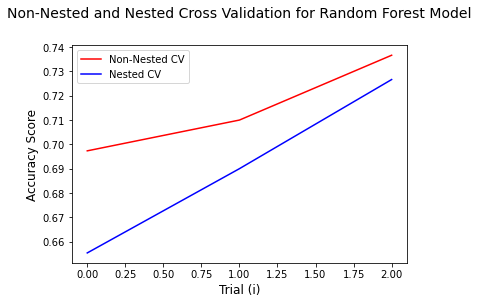

In [35]:
model_used = RandomForestClassifier()
model_name = "Random Forest"
parameter = {'n_estimators':[90,100,120], 'max_features':['sqrt', 'log2'],'max_depth':[80,100],'bootstrap': [True, False]}
NUM_TRIALS = 3

nested_non_nested(model_used,model_name,parameter,NUM_TRIALS)

#Parameter that have been tuned
rf_params = nested_non_nested.final_param
print('Best Parameter for %s model '%model_name + "is: %s"%rf_params)

Mean accuracy Not nested CV: 68.5% ± 2.5%
Mean accuracy Nested CV: 66.4% ± 2.9%
Best Parameter for Gradient Boosting model is: GradientBoostingClassifier(max_depth=5, max_features='sqrt', n_estimators=50)


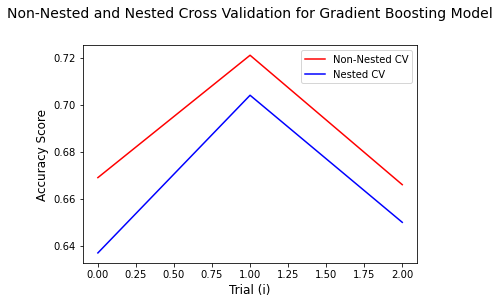

In [112]:
model_used = GradientBoostingClassifier()
model_name = "Gradient Boosting"
parameter = {'n_estimators':[25, 50], 'max_features':['auto', 'sqrt'],'max_depth':[5, 10],'learning_rate': [0.01, 0.1]}
NUM_TRIALS = 3

nested_non_nested(model_used,model_name,parameter,NUM_TRIALS)

#Parameter that have been tuned
gb_params = nested_non_nested.final_param
print('Best Parameter for %s model '%model_name + "is: %s"%gb_params)

Mean accuracy Not nested CV: 76.1% ± 1.7%
Mean accuracy Nested CV: 73.8% ± 1.9%
Best Parameter for Gaussian Naive Bayes model is: GaussianNB(var_smoothing=0.43287612810830584)


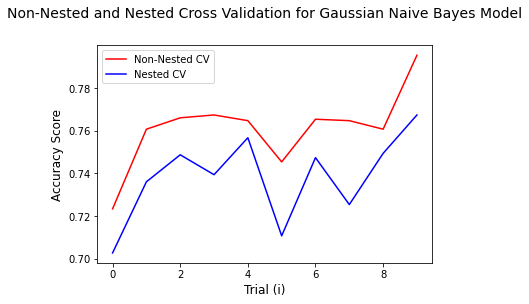

In [36]:
model_used = GaussianNB()
model_name = "Gaussian Naive Bayes"
parameter = {'var_smoothing': np.logspace(0,-9, num=100)}
NUM_TRIALS = 10

nested_non_nested(model_used,model_name,parameter,NUM_TRIALS)

#Parameter that have been tuned
nb_params = nested_non_nested.final_param
print('Best Parameter for %s model '%model_name + "is: %s"%nb_params)

Mean accuracy Not nested CV: 67.2% ± 1.7%
Mean accuracy Nested CV: 63.4% ± 2.7%
Best Parameter for Decision Tree model is: DecisionTreeClassifier(criterion='entropy', max_depth=8, max_features='log2',
                       max_leaf_nodes=22)


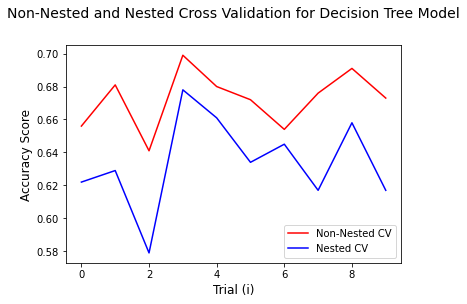

In [13]:
model_used = DecisionTreeClassifier()
model_name = "Decision Tree"
parameter = {'criterion':['gini','entropy'], 'max_depth' : range(3,10,1), 'max_leaf_nodes' : range(20,30,1),'max_features':['auto', 'sqrt', 'log2']}
NUM_TRIALS = 10
nested_non_nested(model_used,model_name,parameter,NUM_TRIALS)

#Parameter that have been tuned
dt_params = nested_non_nested.final_param
print('Best Parameter for %s model '%model_name + "is: %s"%dt_params)


Mean accuracy Not nested CV: 74.6% ± 1.8%
Mean accuracy Nested CV: 71.1% ± 1.9%
Best Parameter for KNN model is: KNeighborsClassifier(metric='euclidean', n_neighbors=1)


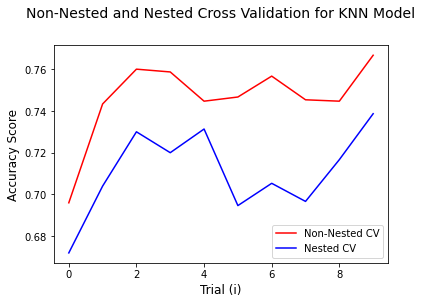

In [38]:
model_used = KNeighborsClassifier()
model_name = "KNN"
parameter = {'n_neighbors':range(1, 5, 1),'weights': ['uniform', 'distance'],'metric':['euclidean', 'manhattan', 'minkowski'] }
NUM_TRIALS = 10
nested_non_nested(model_used,model_name,parameter,NUM_TRIALS)

#Parameter that have been tuned
knn_params = nested_non_nested.final_param
print('Best Parameter for %s model '%model_name + "is: %s"%knn_params)

Mean accuracy Not nested CV: 66.1% ± 1.5%
Mean accuracy Nested CV: 62.2% ± 0.8%
Best Parameter for SVC model is: OneVsRestClassifier(estimator=SVC(C=100, gamma=0.1, kernel='sigmoid',
                                  probability=True))


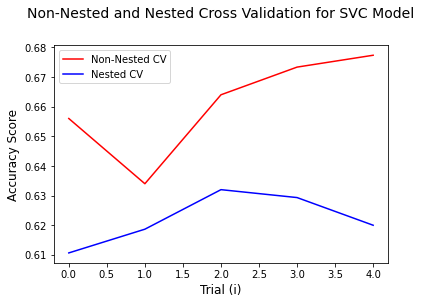

In [39]:
model_used = OneVsRestClassifier(SVC()) 
model_name = "SVC"
parameter = {"estimator__C": [0.1,1, 10, 100], "estimator__gamma": [1,0.1,0.01], 
             "estimator__kernel" : ['poly', 'rbf', 'sigmoid'], 'estimator__probability':[True]} 
NUM_TRIALS = 5

nested_non_nested(model_used,model_name,parameter,NUM_TRIALS)

#Parameter that have been tuned
svc_params = nested_non_nested.final_param
print('Best Parameter for %s model '%model_name + "is: %s"%svc_params)

Mean accuracy Not nested CV: 72.7% ± 2.9%
Mean accuracy Nested CV: 71.8% ± 3.2%
Best Parameter for Logistic Regression model is: OneVsRestClassifier(estimator=LogisticRegression(C=100, max_iter=1000,
                                                 solver='liblinear'))


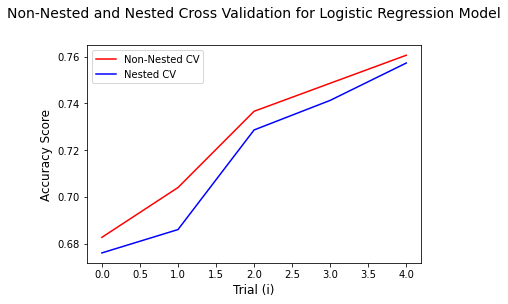

In [40]:
model_used = OneVsRestClassifier(LogisticRegression()) 
model_name = "Logistic Regression"
parameter = {'estimator__solver':['newton-cg', 'lbfgs', 'liblinear','saga'],'estimator__C':[100, 10, 1], 'estimator__max_iter':[1000]}
NUM_TRIALS = 5
nested_non_nested(model_used,model_name,parameter,NUM_TRIALS)

#Parameter that have been tuned
lr_params = nested_non_nested.final_param
print('Best Parameter for %s model '%model_name + "is: %s"%lr_params)

Mean accuracy Not nested CV: 70.6% ± 1.3%
Mean accuracy Nested CV: 68.1% ± 1.7%
Best Parameter for MLP model is: MLPClassifier(learning_rate='invscaling', max_iter=5000, solver='lbfgs')


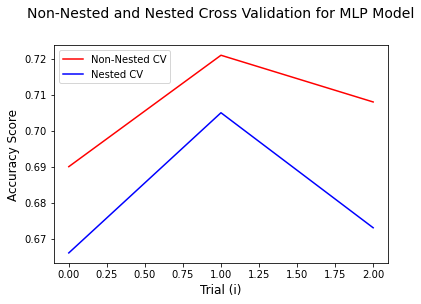

In [111]:
model_used = MLPClassifier()
model_name = "MLP"
parameter = {'solver':['lbfgs','adam','sgd'], 'learning_rate':['constant','invscaling','adaptive'], 'max_iter' :[5000]}
NUM_TRIALS = 3
nested_non_nested(model_used,model_name,parameter,NUM_TRIALS)

#Parameter that have been tuned
mlp_params = nested_non_nested.final_param
print('Best Parameter for %s model '%model_name + "is: %s"%mlp_params)